# Fundamental value model for player prices

TODO: Care can we do feature importance???

TODO: Check interaction between position type and age for example. Goalies can be older, this effects the age situation a bit. Check how to sort this out. Or do the Random forest headroom trick
acknowledge that could deal with this problem a little. Then identify some potentially undervalued bois.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
# Import from files...
df1 = pd.read_csv('matchday_scores.csv')
df1['Date'] = pd.to_datetime(df1['Date'], format='%d/%m/%Y')

df2 = pd.read_csv('player_info.csv')
df2.set_index('PlayerName', inplace=True)

In [4]:
# Extract average matchday score since game x
season_start = '2020-09-12' # Start of UK football season
df1 = df1[df1['Date'] >= season_start]

ave_matchday_score = df1.groupby('PlayerName')['MatchdayScore'].mean()
num_games_played = df1.groupby('PlayerName').size()

df2['ave_matchday_score'] = ave_matchday_score
df2['num_games_played'] = num_games_played

df = df2[['Position', 'Age', 'num_games_played', 'ave_matchday_score',  'CurrentPrice']]

# Clean up df
df['CurrentPrice'] = df['CurrentPrice'].str.strip('£').astype('float64')

C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
# Generate positional dummies
df = pd.get_dummies(df, prefix='', prefix_sep='')

yX = df[df['num_games_played'] >= 5]

# Regress
y = yX['CurrentPrice']
X = yX[['Age', 'ave_matchday_score', #'num_games_played', 
        'Forward', 'Midfielder', 'Defender', 'Goalkeeper']]

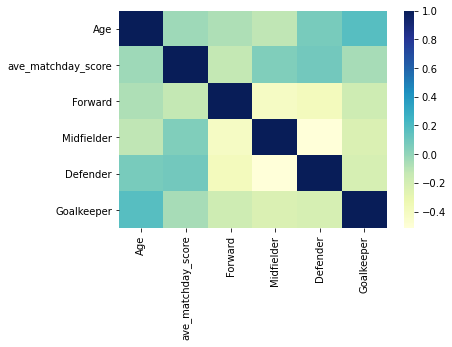

In [6]:
# Check for multicollinearity among explanatory vars
corr_table = X.corr()
#mask = np.zeros_like(corr_table)
#mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_table, cmap="YlGnBu")

In [7]:
# Proceed
model = sm.OLS(y, X).fit(cov_type='HC0')
model.summary()

C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CurrentPrice   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 14 Nov 2020   Prob (F-statistic):                nan
Time:                        10:01:16   Log-Likelihood:                -1380.4
No. Observations:                1358   AIC:                             2773.
Df Residuals:                    1352   BIC:                             2804.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age                   -0.0641      0.006    -11.439      0.000      -0.075      -0.053
ave_matchday_score     0.0093      0.001      9.977      0.000       0.007       0.011
Forward                2.2519      0.156     14.424      0.000       1.946       2.558
Midfielder             1.8854      0.154     12.239      0.000       1.584       2.187
Defender               1.6859      0.155     10.855      0.000       1.381       1.990
Goalkeeper             1.7877      0.162     11.060      0.000       1.471       2.105
==============================================================================
Omnibus:                     1252.217   Durbin-Watson:                   1.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51950.702
Skew:                           4.248   Prob(JB):                         0.00
Kurtosis:                      32.085   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Optimise your spec

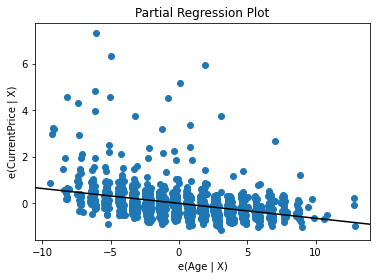

In [9]:
# Consider 
sm.graphics.plot_partregress('CurrentPrice', 'Age', ['ave_matchday_score', 'Forward', 'Midfielder', 'Defender', 'Goalkeeper'], data=yX, obs_labels=False);

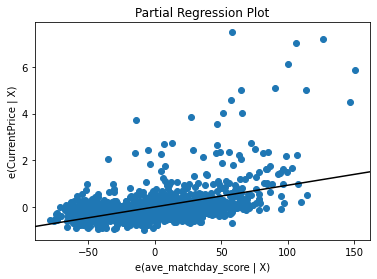

In [11]:
sm.graphics.plot_partregress('CurrentPrice', 'ave_matchday_score', ['Age', 'Forward', 'Midfielder', 'Defender', 'Goalkeeper'], data=yX, obs_labels=False);
# SAY THEY COULD BE OUTLIERS THO. lOOK AT THEM PLOTS, THEY'RE PRETTY WILD
# Can you label outliers?

In [25]:
# Adding in non-linear terms
yX['Age2'] = yX['Age']**2
yX['ave_matchday_score2'] = yX['ave_matchday_score']**2

X_adjusted = yX[['Age', 'Age2', 'ave_matchday_score', 'ave_matchday_score2',#'num_games_played', 
        'Forward', 'Midfielder', 'Defender', 'Goalkeeper']]

model = sm.OLS(y, X_adjusted).fit(cov_type='HC0')
model.summary()

C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CurrentPrice   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 14 Nov 2020   Prob (F-statistic):                nan
Time:                        11:06:15   Log-Likelihood:                -1248.4
No. Observations:                1358   AIC:                             2513.
Df Residuals:                    1350   BIC:                             2554.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                    -0.4850      0.068     -7.095      0.000      -0.619      -0.351
Age2                    0.0077      0.001      6.409      0.000       0.005       0.010
ave_matchday_score     -0.0071      0.002     -3.049      0.002      -0.012      -0.003
ave_matchday_score2     0.0001    2.1e-05      5.718      0.000     7.9e-05       0.000
Forward                 8.2421      0.957      8.611      0.000       6.366      10.118
Midfielder              7.9443      0.957      8.306      0.000       6.070       9.819
Defender                7.7180      0.953      8.102      0.000       5.851       9.585
Goalkeeper              7.7938      0.952      8.190      0.000       5.929       9.659
==============================================================================
Omnibus:                     1109.675   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38245.562
Skew:                           3.558   Prob(JB):                         0.00
Kurtosis:                      28.006   Cond. No.                     5.60e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 5.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# Adding interaction terms
yX['Age_Defender'] = yX['Defender'] * yX['Age'] 
yX['Age_Midfielder'] = yX['Midfielder'] * yX['Age']
yX['Age_Forward'] = yX['Forward'] * yX['Age']
yX['Age_Goalkeeper'] = yX['Goalkeeper'] * yX['Age']

yX['Age3'] = yX['Age'] ** 3

X_interactions = yX[['Age_Forward', 'Age_Midfielder', 'Age_Defender', 'Age_Goalkeeper', 
                     'ave_matchday_score', 'ave_matchday_score2', 'Age2', 'Age3',#'num_games_played', 
                     'Forward', 'Midfielder', 'Defender', 'Goalkeeper']]

model = sm.OLS(y, X_interactions).fit(cov_type='HC0')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CurrentPrice   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 14 Nov 2020   Prob (F-statistic):                nan
Time:                        11:25:38   Log-Likelihood:                -1229.8
No. Observations:                1358   AIC:                             2484.
Df Residuals:                    1346   BIC:                             2546.
Df Model:                          11                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age_Forward            -2.0774      0.452     -4.594      0.000      -2.964      -1.191
Age_Midfielder         -2.0850      0.452     -4.613      0.000      -2.971      -1.199
Age_Defender           -2.0625      0.451     -4.578      0.000      -2.946      -1.179
Age_Goalkeeper         -2.0435      0.450     -4.545      0.000      -2.925      -1.162
ave_matchday_score     -0.0070      0.002     -2.982      0.003      -0.012      -0.002
ave_matchday_score2     0.0001   2.11e-05      5.698      0.000    7.88e-05       0.000
Age2                    0.0667      0.016      4.179      0.000       0.035       0.098
Age3                   -0.0007      0.000     -3.855      0.000      -0.001      -0.000
Forward                22.3363      4.241      5.267      0.000      14.025      30.648
Midfielder             22.2400      4.228      5.260      0.000      13.953      30.527
Defender               21.4111      4.187      5.114      0.000      13.205      29.617
Goalkeeper             20.9470      4.168      5.026      0.000      12.778      29.116
==============================================================================
Omnibus:                     1096.672   Durbin-Watson:                   1.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37315.328
Skew:                           3.497   Prob(JB):                         0.00
Kurtosis:                      27.710   Cond. No.                     7.66e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 7.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We get a nice bump of 10% in R^2. From simple changes to model. (likely no-overfit)
Res plots also reinforce use of HC0 standard errors. 

In the interest of Occam's protocol, we choose the first, and since we are explicitly looking for outlying data which denotes under-valued players we use this.

Checking for headroom, do a cheeky random forest, (or short and sweet???)

We will compare predictive capabilities of random forest and our OLS spec. for predictive power
as a point of interest, to observe when increasing model complication, how predictable are player prices
from these sparse factors, and in turn, have we over-simplified our ols spec. there is more to be gained in here from
modelling more subtle non-linearities and interactions.